# Лабораторная работа №1


#### *Класс GraphBuilder*

занимеается построением графиков

**Описание класса**

*   drow_histogram() - метод для построения гитсрограммы
*   drow_empirical_series() - метод для построения эмпирической функции распределения
* drow_boxplot() - метод для построения графика box_plot
* drow_normail_distribution() - метод для построения нормального распределения
* drow_gamma_distribution() - метод для построения гамма распределения



In [55]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

class GraphBuilder:

    def drow_histogram(self, heading, arr, h):
        centers = list()
        values = list()

        for item in arr:
            centers.append(item)
            values.append(arr[item]) # для вероятностей
        plt.bar(centers, values, edgecolor='k', width=h, fc=(0, 0, 1, 0.5))
        plt.grid(False)
        plt.xlabel('x')
        plt.ylabel('p')
        plt.title(heading)
        plt.show()

    def drow_empirical_series(self, heading, empirical_series):
        x_coord = []
        y_coord = []
        for item in empirical_series:
            x_coord.append(item[0])
            x_coord.append(item[1])
            y_coord.append(empirical_series[item])
            y_coord.append(empirical_series[item])
            plt.plot(x_coord, y_coord, color='c')

        plt.grid(True)
        plt.xlabel('x')
        plt.ylabel('F*(x)')
        plt.title(heading)
        plt.show()

    def drow_boxplot(self, heading, arr):
        plt.boxplot(arr)
        plt.title(heading)
        plt.show()

    def drow_normail_distribution(self):
        x = np.arange(-5, 5, 0.01)
        plt.plot(x, stats.norm.pdf(x), color="red")

    def drow_gamma_distribution(self, shape):
        x = np.arange(0.01, 10, 0.01)
        plt.plot(x, stats.gamma.pdf(x, shape), color="red")


#### *Класс Solver*


**Описание класса**

проводит основные вычисления в программе

* Поля
  *   numbers - выборка, для которой класс вычисляет характеристики
  *   __empirical_series - по оканчании метода solve() в массиве будут лежать точки для построения эмпирической функции распределения
  *   __heading - заголовок для выборки
  *  __statistical_series - по оканчании метода solve() в массиве будут лежать точки для построения гистограммы вероятностей
  *  __normalized_statistical_series - по оканчании метода solve() в массиве будут лежать точки для построения **нормализованной и смещенной** гистограммы вероятностей
  *  __h - длина промежутка для гисторгаммы вероятностей
  *  __normalized_h - длина промежутка для **нормализованной и смещенной** гисторгаммы вероятностей

* Методы
  * find_interval_statistical_series() - возвращает точки для построения интервального статистического ряда (для гистограммы)
  * print_cvantil(self, cvantil) - единственный метод в классе, не входящий в метод solve(). Нужен для нахождения выборочной квантили заданного порядка
  * find_empirical_series() - возвращает точки для построения эмпирической функции
  * find_h() - вспомогательный метод для нахождения интервального промежутка по правилу Стёрджеса
  * find_median() - метод для нахождения медианы выборки
  * solver() - главный метод класса. Служит для расчета и последующего вывода основных характеристик входной выборки

In [56]:
from math import log2, ceil
import numpy as np

class Solver:
    numbers: list[float] = None

    __empirical_series = {}

    __heading: str = ""

    __statistical_series = {}

    __normalized_statistical_series = {}

    __h = 0

    __normalized_h = 0

    def get_h(self):
        return self.__h

    def get_x_for_normal_dist(self):
        return self.__x_for_normal_dist

    def get_y_for_normal_dist(self):
        return self.__y_for_normal_dist

    def get_normalized_h(self):
        return self.__normalized_h

    def get_heading(self):
        return self.__heading

    def get_statistical_series(self):
        return self.__statistical_series

    def get_normalized_statistical_series(self):
        return self.__normalized_statistical_series

    def get_empirical_series(self):
        return self.__empirical_series

    def find_median(self, selection): # медиана или квантиль 0.5
        selection_size = len(selection)
        if selection_size % 2 == 0:
            return (selection[selection_size // 2] + selection[selection_size // 2 - 1]) / 2
        return selection[selection_size // 2 - 1]

    def find_h(self, arr):
        h = (max(arr) - min(arr)) / (1 + log2(len(arr))) # Найндем длину промежутка по формуле Стрерджеса
        h /= 2 # + делим интервал на 2 (выглядит круче)
        return h

    def find_interval_statistical_series(self, arr): # Интервальный статистический ряд
        h = self.find_h(arr)
        current_start = min(arr)
        numbers = ceil((max(arr) - current_start) / h)
        current_end = current_start + h
        ret_arr = {}
        for i in range(numbers):
            frequency = 0
            for item in arr:
                if current_start <= item < current_end:
                    frequency += 1
            ret_arr[(current_start + current_end) / 2] = frequency / len(self.numbers) / h
            current_start = current_end
            current_end += h
        return ret_arr

    def find_empirical_series(self, arr): # Эмпиричейчкий ряд
        current_probability : float = 0
        previous =  float("-inf")
        ret_dict = {}
        for i in arr:
            if previous == float("-inf"):
                ret_dict[(i - (max(arr) - min(arr)) * 0.05, i)] = current_probability
            else:
                ret_dict[(previous, i)] = current_probability
            current_probability += 1 / len(arr)
            previous = i
        ret_dict[(previous, previous + (max(arr) - min(arr)) * 0.05)] = current_probability
        return ret_dict

    def print_cvantil(self, cvantil):
        number = cvantil * len(self.numbers)
        for i in range(len(self.numbers)):
            if i > number:
                print(f'Квантиль {cvantil} = {self.numbers[i]}')
                return
        print(f'Error in find_cvantil')

    def solve(self, numbers, heading):
        self.__heading = heading
        self.__empirical_series = {}
        self.__statistical_series = {}
        self.__normalized_statistical_series = {}
        self.numbers = sorted(numbers)

        mean = np.mean(self.numbers)
        std = np.std(self.numbers)
        normalized_data = [(i - mean) / std for i in self.numbers]

        print(f"------ {heading} ------")
        print("Экстремальные значения:: Минимум:", min(self.numbers), "Максимум:", max(self.numbers))
        print("Размах:", round(max(self.numbers) - min(self.numbers), 3))
        print("Среднее выборочное:", round(mean, 5))
        print("Выборочная дисперсия:", round(std, 5))
        print("Медиана (квантиль 0.5):", round(self.find_median(self.numbers), 5))

        self.__normalized_statistical_series = self.find_interval_statistical_series(normalized_data)
        self.__normalized_h = self.find_h(normalized_data)
        self.__statistical_series = self.find_interval_statistical_series(self.numbers)
        self.__h = self.find_h(self.numbers)
        self.__empirical_series = self.find_empirical_series(self.numbers)


#### Общий импорт для заданий

In [ ]:
import random
import numpy as np
import scipy.stats as stats
import pandas as pd

## Задание №1

### **Текст задания**









Выберите распределение, у которого существуют первые четыре момента, и экспериментально убедитесь в асимптотической нормальности выборочного среднего,выборочной дисперсии, выборочной квантили порядка 0.5 для данного распределения. Также экспериментально убедитесь в том, что

nF(X(2))→U1∼Γ(2,1)  и  n(1−F(X(n)))→U2∼Γ(1,1)=Exp(1) .

Указание: сгенерируйте достаточно большое количество выборок достаточно большого объема, для каждой сгенерированной выборки вычислите соответсвующие статистики (функции от выборок), постройте гистограммы результатов для каждой статистики,для наглядности рядом с гистограммой можно нарисовать соответствующую плотность (пока это метод ''на глаз'', но в дальнейшем мы разберем статистическую процедуру, позволяющую проверить согласованность распределения выборки с заданным вероятностным законом), также можно помимо гистограммы вывести мат. ожидание, дисперсию (или стандартное отклонение) и медиану.

### **Исходный код**

В методе происходит генерация *selection_count* выборок, каждая из которых - размера *selection_size* и находится на интервале [*interval_begin; interval_end*].

Далее по ним строится три выборки для:
*  медианы
*  дисперсии
*  математического ожидания

Затем метод строит гистограммы для каждой из статистик, и показывает "на глаз", что их распределение подчиняется нормальному

По-мимо этого метод строит распределение еще двух выборок, где $F(x)$ - это функция равномерного расрпеделения:
* $n\cdot(1 - F(x_{max}))$ - идентичен гамма распределению $Г(1, 1)$
* $n\cdot F(x_{min})$ - идентичен гамма распределению $Г(2, 1)$

In [61]:
def task1():
    print("-------- Задание 1 --------")
# Настройка программы
    interval_begin = 0 # интервал для случайных выборок
    interval_end = 10 # конец должен быть больше начала
    selection_size = 100 # размер выборки
    selection_count = 10000 # количество выборок

    solver = Solver()
    graph_builder = GraphBuilder()
    math_expectation_arr = list()
    variance_arr = list()
    median_arr = list()
    low_values_arr = list()
    max_values_arr = list()
    uniform = stats.uniform(interval_begin, interval_end) # функция с равномерным распределением


    def generate_selection():
        return [random.random() * (interval_end - interval_begin)  + interval_begin for i in range(selection_size)]

    for i in range(selection_count):
        curr_selection = sorted(generate_selection()) # генерация
        low_values_arr.append(uniform.cdf(curr_selection[1]) * selection_size)
        max_values_arr.append((1 - uniform.cdf(curr_selection[selection_size - 1])) * selection_size)
        math_expectation_arr.append(np.mean(curr_selection)) # мат ожидание
        variance_arr.append(np.std(curr_selection)) # дисперсия
        median_arr.append(solver.find_median(curr_selection)) # медиана
    solver.solve(math_expectation_arr, "Выборочное среднее")
    graph_builder.drow_normail_distribution()
    graph_builder.drow_histogram(solver.get_heading(), solver.get_normalized_statistical_series(), solver.get_normalized_h())
    solver.solve(variance_arr, "Выборочная дисперсия")
    graph_builder.drow_normail_distribution()
    graph_builder.drow_histogram(solver.get_heading(), solver.get_normalized_statistical_series(), solver.get_normalized_h())
    solver.solve(median_arr, "Медиана")
    graph_builder.drow_normail_distribution()
    graph_builder.drow_histogram(solver.get_heading(), solver.get_normalized_statistical_series(), solver.get_normalized_h())
    solver.solve(low_values_arr, "Low values")
    graph_builder.drow_gamma_distribution(2)
    graph_builder.drow_histogram(solver.get_heading(), solver.get_statistical_series(), solver.get_h())
    solver.solve(max_values_arr, "Max values")
    graph_builder.drow_gamma_distribution(1)
    graph_builder.drow_histogram(solver.get_heading(), solver.get_statistical_series(), solver.get_h())

### **Результат**

-------- Задание 1 --------
------ Выборочное среднее ------
Экстремальные значения:: Минимум: 3.7978740442416723 Максимум: 6.061197099184568
Размах: 2.263
Среднее выборочное: 5.00107
Выборочная дисперсия: 0.2895
Медиана (квантиль 0.5): 5.00442


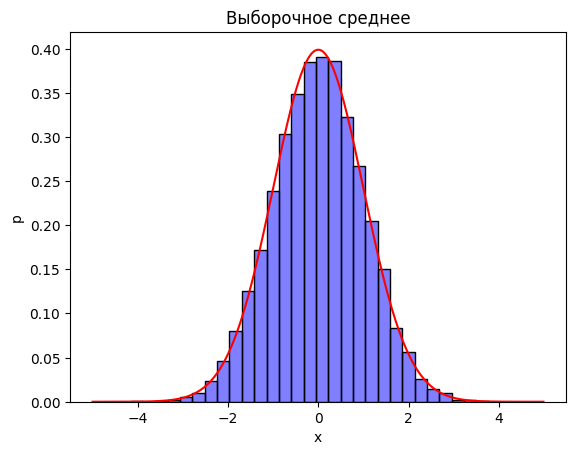

------ Выборочная дисперсия ------
Экстремальные значения:: Минимум: 2.359204473773244 Максимум: 3.3610835843514977
Размах: 1.002
Среднее выборочное: 2.86946
Выборочная дисперсия: 0.13187
Медиана (квантиль 0.5): 2.86891


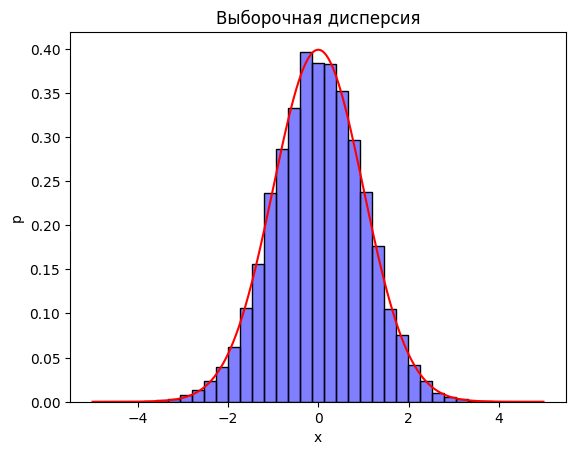

------ Медиана ------
Экстремальные значения:: Минимум: 3.3295779326816533 Максимум: 6.821284514972848
Размах: 3.492
Среднее выборочное: 5.00166
Выборочная дисперсия: 0.49631
Медиана (квантиль 0.5): 5.00381


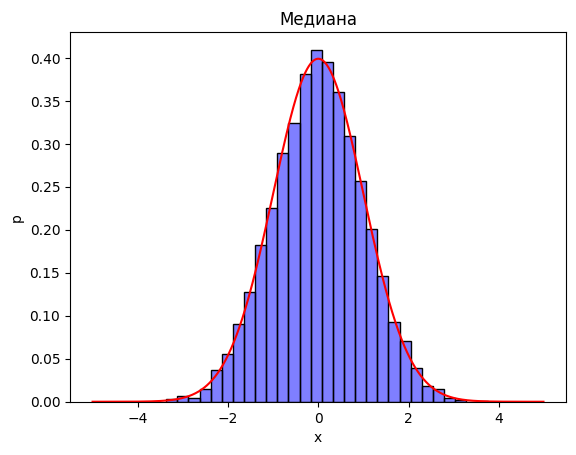

------ Low values ------
Экстремальные значения:: Минимум: 0.0045975174075563174 Максимум: 10.896110963109617
Размах: 10.892
Среднее выборочное: 2.00063
Выборочная дисперсия: 1.37325
Медиана (квантиль 0.5): 1.69811


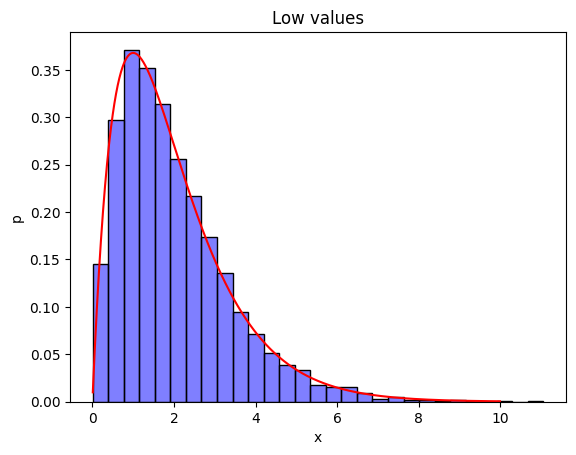

------ Max values ------
Экстремальные значения:: Минимум: 0.00017444593719551094 Максимум: 10.523258578976268
Размах: 10.523
Среднее выборочное: 0.99698
Выборочная дисперсия: 0.99495
Медиана (квантиль 0.5): 0.68983


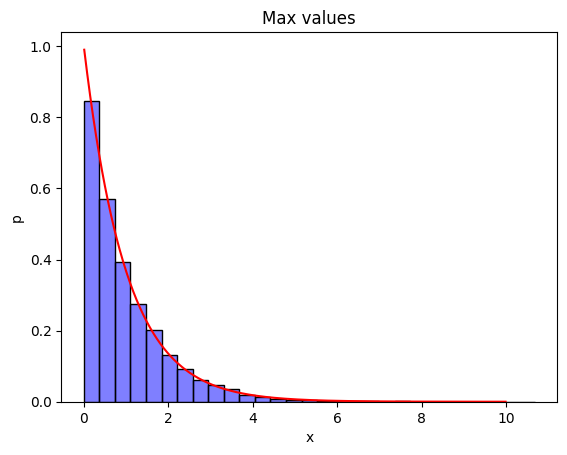

In [58]:
task1()

## Задание №2

### **Текст задания**

В файле mobile_phones.csv приведены данные о мобильных телефонах. В сколько моделей можно вставить 2 сим-карты, сколько поддерживают 3-G, каково наибольшее число ядер
у процессора? Рассчитайте выборочное среднее, выборочную дисперсию, выборочную медиану и выборочную квантиль порядка 2/5, построить график эмпирической функции
распределения, гистограмму и box-plot для емкости аккумулятора для всей совокупности
и в отдельности для поддерживающих/не поддерживающих Wi-Fi.

### **Исходный код**

В методе сначала вычисляется несколько статистических значений, по заданию. Затем составляется три выборки:


*   Общая выборка всех телефонов
*   Выборка телефонов, поддреживающий Wi-Fi
*   Выборка телефонов, неподдерживающих Wi-Fi

Затем для каждой выборки вычисляются необходимые характеристики, выводятся на экран. А также строятся графики эмпирической функции распределения, гистрограмма вероятностей и box_plot



In [59]:
def task2():
    print("-------- Задание 2 --------")
    csv_dict = pd.read_csv("mobile_phones.csv", sep=",").to_dict()
    print(f"В {sum(csv_dict['dual_sim'].values())} можно вставить 2 сим карты")
    print(f"{sum(csv_dict['three_g'].values())} телефонов поддерживают 3G")
    print(f"{max(csv_dict['n_cores'].values())} - наибольшее количество ядер среди всех телефонов")

    all_battery_power = csv_dict['battery_power'].values()
    battery_power_with_wifi = []
    battery_power_without_wifi = []
    # getting values
    for i in range(len(csv_dict['battery_power'])):
        if csv_dict['wifi'][i] == 1:
            battery_power_with_wifi.append(csv_dict['battery_power'][i])
        else:
            battery_power_without_wifi.append(csv_dict['battery_power'][i])

    solver = Solver()
    graph_builder = GraphBuilder()
    solver.solve(all_battery_power, "Общая выборка")
    solver.print_cvantil(2 / 5)
    graph_builder.drow_histogram(solver.get_heading(), solver.get_statistical_series(), solver.get_h())
    graph_builder.drow_empirical_series(solver.get_heading(), solver.get_empirical_series())
    graph_builder.drow_boxplot(solver.get_heading(), solver.numbers)
    solver.solve(battery_power_with_wifi, "Выборка с наличием Wi-Fi")
    solver.print_cvantil(2 / 5)
    graph_builder.drow_histogram(solver.get_heading(), solver.get_statistical_series(), solver.get_h())
    graph_builder.drow_empirical_series(solver.get_heading(), solver.get_empirical_series())
    graph_builder.drow_boxplot(solver.get_heading(), solver.numbers)
    solver.solve(battery_power_without_wifi, "Выборка с отсутствием Wi-Fi")
    solver.print_cvantil(2 / 5)
    graph_builder.drow_histogram(solver.get_heading(), solver.get_statistical_series(), solver.get_h())
    graph_builder.drow_empirical_series(solver.get_heading(), solver.get_empirical_series())
    graph_builder.drow_boxplot(solver.get_heading(), solver.numbers)

### **Результат**

-------- Задание 2 --------
В 1019 можно вставить 2 сим карты
1523 телефонов поддерживают 3G
8 - наибольшее количество ядер среди всех телефонов
------ Общая выборка ------
Экстремальные значения:: Минимум: 501 Максимум: 1998
Размах: 1497
Среднее выборочное: 1238.5185
Выборочная дисперсия: 439.30834
Медиана (квантиль 0.5): 1226.0
Квантиль 0.4 = 1077


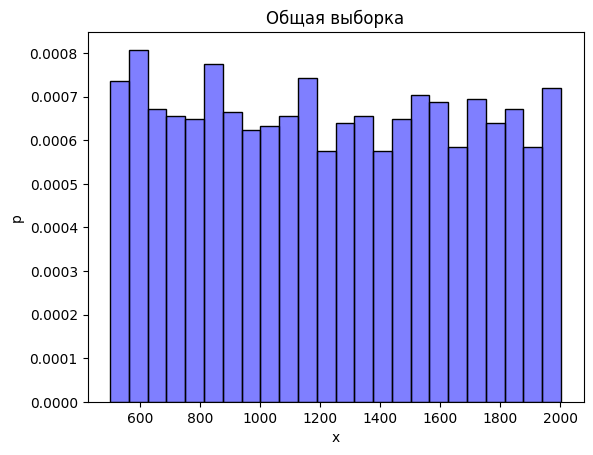

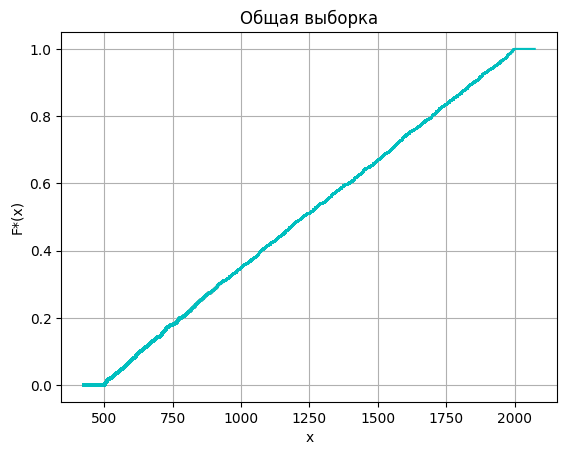

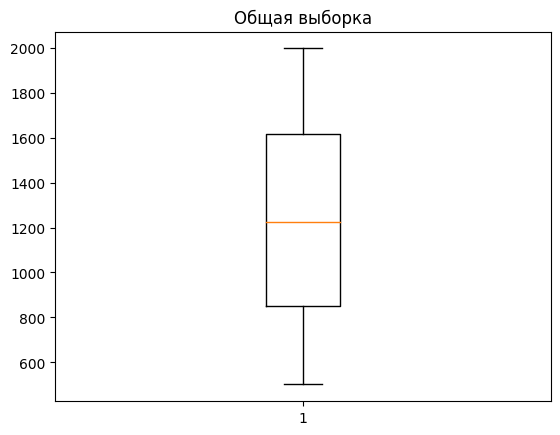

------ Выборка с наличием Wi-Fi ------
Экстремальные значения:: Минимум: 501 Максимум: 1996
Размах: 1495
Среднее выборочное: 1234.90434
Выборочная дисперсия: 436.0146
Медиана (квантиль 0.5): 1233.0
Квантиль 0.4 = 1081


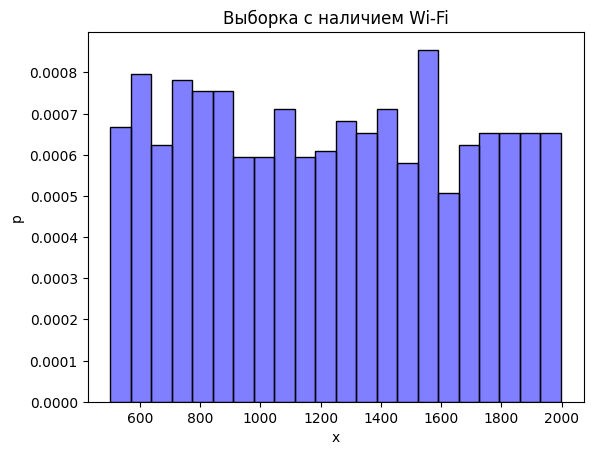

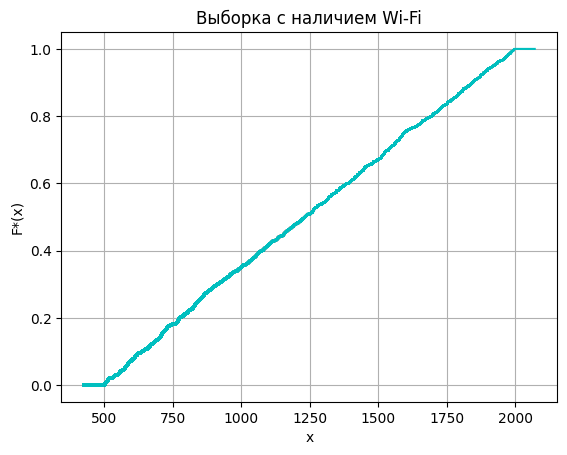

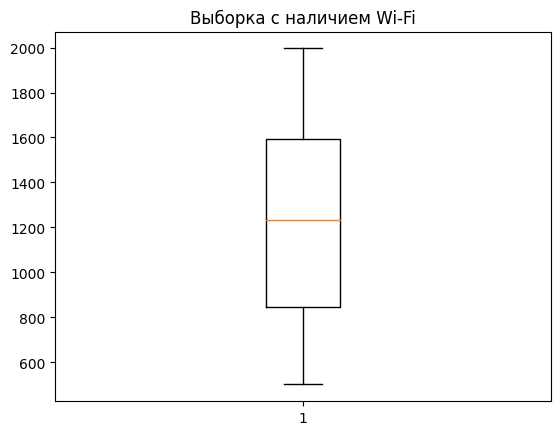

------ Выборка с отсутствием Wi-Fi ------
Экстремальные значения:: Минимум: 501 Максимум: 1998
Размах: 1497
Среднее выборочное: 1242.23529
Выборочная дисперсия: 442.63927
Медиана (квантиль 0.5): 1222.0
Квантиль 0.4 = 1076


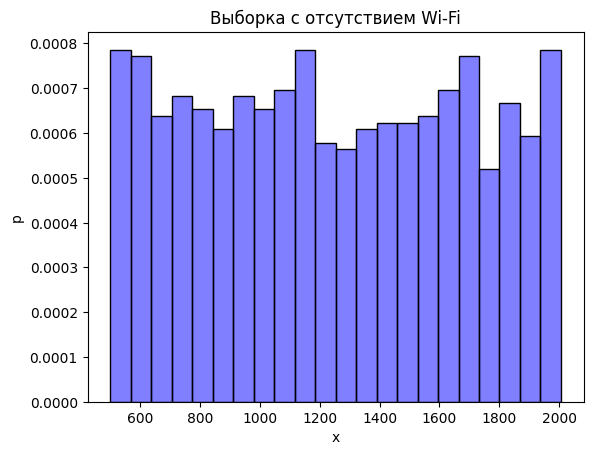

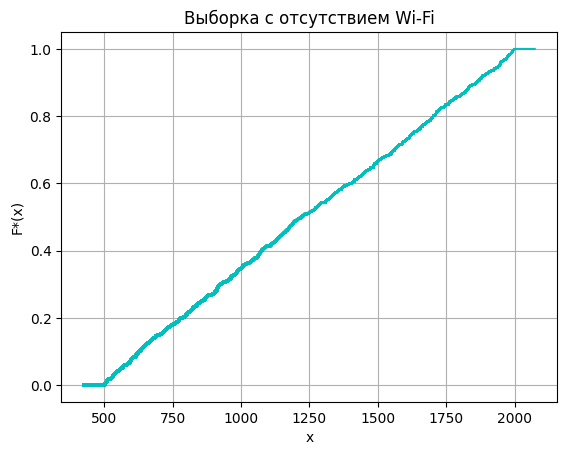

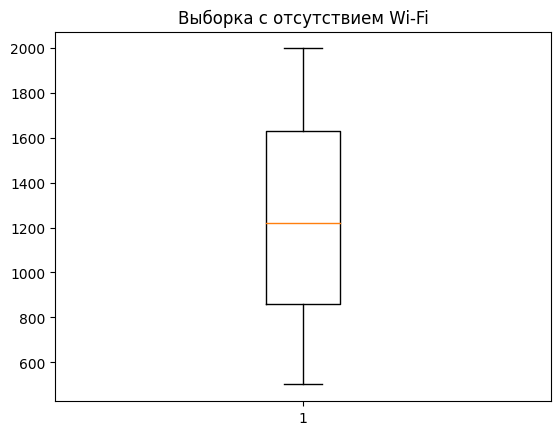

In [60]:
task2()